## Lab 7 (Image Processing using Convolutional Neural Networks)
- CIFAR10 dataset (see https://www.cs.toronto.edu/~kriz/cifar.html for more info)
- 60K images: 50K train, 10K test
- 10 classes: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
- Perform multi-class classification with evaluation accuracy on EACH class

**CONNECT TO GPU** before continuing, but just CPU is also fine, it might be a bit slow.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# Download and prepare dataset
# Transform them to tensors and normalise them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data
train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

# 2.3 Use DataLoader to get batches and shuffle
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Q1. Why are there 3 values in each list of the Normalize() function? What does each value and each list represent?

# The Normalize() function normalize a tensor image with a mean and standard
# deviation for n channels, meaning this normalize each channel of the input.
# So the value in the first list is the mean and the values in the
# second list is the standard deviation. Each list have three values due to the
# dimensions of the image.


# There are three since there are three channels.
# The first tuple gives the mean value of color channel in the image data.
# The second tuple gives the standard deviation of each color channel in the image.
# Each image pixel value in a particular channel will subtrac tthe provided mean
# and the std to get a normalized value.

cuda
Files already downloaded and verified
Files already downloaded and verified


### Inspect the Images

In [ ]:
# Access the first data sample in the train_set using next(iter())
batch = next(iter(train_loader))
print(f'Image values: \n{batch}')
print(f'Length: {len(batch)}')
print(f'Type: {type(batch)}')

# This means the data contains image-label pairs
# Unpack them
images, labels = batch
# Same as these two lines:
# image = batch[0]
# label = batch[1]


print(images.shape)
print(labels)

# Q2. What is the range of the values for the normalised image pixels?

# Then range is from -1 to 1.

# Q3. What does each index value of the shape of the image represent?

# Batch size, Channel, and Dimensions (height and width) of image

# Q4. What do the label values represent?

# The label values represent the classes of the image.


Image values: 
[tensor([[[[-0.1922, -0.1059, -0.8039,  ..., -0.2706, -0.2392, -0.4039],
          [-0.2941, -0.1216, -0.2941,  ..., -0.2000, -0.2549, -0.3098],
          [-0.0039, -0.1373, -0.0118,  ..., -0.2863, -0.4118, -0.2784],
          ...,
          [-0.0745,  0.2157,  0.3882,  ...,  0.1059,  0.1216,  0.0824],
          [-0.1294,  0.3176,  0.5137,  ...,  0.1137,  0.2549,  0.0745],
          [-0.1608,  0.3176,  0.5059,  ...,  0.0667,  0.4039,  0.1686]],

         [[-0.1373, -0.0588, -0.7569,  ..., -0.1843, -0.1686, -0.3490],
          [-0.2314, -0.0588, -0.2235,  ..., -0.1294, -0.1843, -0.2549],
          [ 0.0588, -0.0667,  0.0588,  ..., -0.2157, -0.3412, -0.2157],
          ...,
          [ 0.0039,  0.3098,  0.4588,  ...,  0.1294,  0.1373,  0.1137],
          [-0.0667,  0.3961,  0.5686,  ...,  0.1529,  0.2941,  0.1059],
          [-0.1216,  0.3725,  0.5529,  ...,  0.1373,  0.4667,  0.2157]],

         [[-0.1608, -0.0745, -0.7569,  ..., -0.2157, -0.1922, -0.3725],
          [-0.

### View some images
- Note that images have been normalised and may not look very clear

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class labels: tensor([6, 9, 8, 3])


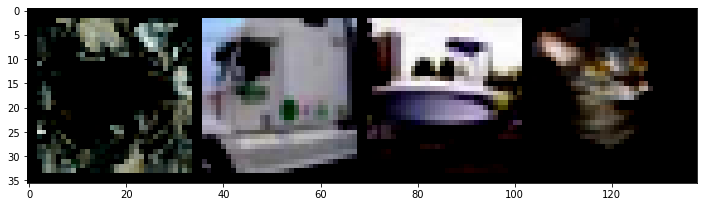

In [ ]:
# Create a grid
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

## CNN model

In [ ]:
class Test(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5, padding = 1) # input 3 channel, apply 6 filters, with each filter being a 5x5
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2) # kernel size = 2, stride = 2
    self.conv2 = nn.Conv2d(6, 16, 5) # input 6 channels from conv1,
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(16*5*5, 128) # Q8. Fill out the correct input dimensions
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    print(f'Input shape: {x.shape}')
    out = self.conv1(x)
    print(f'After Conv1: {out.shape}')
    print(f'Padding: {self.conv1.padding}')
    out = self.pool(F.relu(out))
    print(f'After Pool1: {out.shape}')
    out = self.conv2(out)
    print(f'After Conv2: {out.shape}')
    out = self.pool(F.relu(out))
    print(f'After Pool2: {out.shape}')
    # Flatten it before fc1
    out = out.reshape(-1, 16*5*5) # Q8. Fill out the correct dimension after -1
    print(f'Before fc1: {out.shape}')
    out = self.fc1(out)
    out = self.relu(out)
    print(f'After fc1: {out.shape}')
    out = self.fc2(out)
    out = self.relu(out)
    print(f'After fc2: {out.shape}')
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    print(f'After fc3: {out.shape}')
    return out


model = Test().to(device)
# Let's view the softmax output
probs = nn.Softmax(dim=1)


# Q5. What do the three arguments of the first convolutional layer, conv1 represent (3,6,5)?

# conv1 applies a 2D convulution over an input. So the numbers represents the
# in_channels (number of channels in the input image), out_channels (number of
# channels produced by the convolution), and the kernel_size (size of the
# convolving kernel stride).

# input = 3 channels, output = 6 meaning there is 6 filter map, filter size = 5x5

# Q6. Explain the arguments of the second convolutional layer, conv2 (6, 16, 5)

# The 6 represents the channels of the input from the first convolutional layer.
# The 16 represents the number of channels produced by the convolution. The 5
# presents the size of the convolving kernel stride.

# Q7. Figure out the convolved image size after conv1
# Convolved image size = ((input_width - filter_size + 2 * padding) / stride) + 1

# convolved image size = ((32- 5 + 2*0)/1) +1 = 28

# Q8. Figure out the input size to the first fcn layer and fill out the code above in init() and forward()


### Run through a sample batch

In [ ]:
sample = next(iter(train_loader))

images, labels = sample

images = images.to(device)
labels = labels.to(device)

output = model(images)
print(f'Output shape: {output.shape}')
print(f'Softmax outputs:\n {probs(output)}')


# Q9. Explain the shape of the output after conv1

# After conv1, the shape was [4, 6, 28, 28]. This tells us about the number of
# channels and dimensions of the image.

# Q10. What does the pooling do to the dimensions of the feature images here?

# Pooling compresses the image. Width and height halved.

# Q11. Add padding=1 to conv1 and rerun the last two code cells. How did padding affect the dimensions of the feature images?

# The dimensions of the images are larger. After conv1 the dimensions are 30x30
# and not 28x28. The dimensions of the images up until after conv2 is larger.


# Q12. What is represented by each list returned by Softmax outputs?

# The probability of the classes of images in the order of
# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.


Input shape: torch.Size([4, 3, 32, 32])
After Conv1: torch.Size([4, 6, 30, 30])
Padding: (1, 1)
After Pool1: torch.Size([4, 6, 15, 15])
After Conv2: torch.Size([4, 16, 11, 11])
After Pool2: torch.Size([4, 16, 5, 5])
Before fc1: torch.Size([4, 400])
After fc1: torch.Size([4, 128])
After fc2: torch.Size([4, 64])
After fc3: torch.Size([4, 10])
Output shape: torch.Size([4, 10])
Softmax outputs:
 tensor([[0.0959, 0.1097, 0.1027, 0.0991, 0.1122, 0.0993, 0.0925, 0.0947, 0.0954,
         0.0984],
        [0.0962, 0.1096, 0.1025, 0.0991, 0.1124, 0.0987, 0.0934, 0.0951, 0.0947,
         0.0982],
        [0.0961, 0.1086, 0.1035, 0.0995, 0.1134, 0.0997, 0.0929, 0.0934, 0.0948,
         0.0980],
        [0.0969, 0.1107, 0.1028, 0.0984, 0.1124, 0.0987, 0.0927, 0.0950, 0.0945,
         0.0980]], device='cuda:0', grad_fn=<SoftmaxBackward0>)



### Let's Train!
- Now that we know and understand how CNNs work, let's put everything together for CIFAR-10 dataset
  - Download the data in batches and normalisation with shuffling
  - Build a model with 2 CNN layers containing ReLU and pooling
  - Passing the feature images to 3 fully connected layers (FCNs) also containing RELU activation
  - The final layer has 10 units to reprsent the number of output classes
  - Use Binary Cross Entropy Loss and SGD optimiser
  - Evaluate the model on the test data on EACH class

**IMPORTANT!** Fill out the missing code below before training

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(16*5*5, 128) # TODO
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    # Flatten it before fc1
    out = out.reshape(-1, 16*5*5) # TODO
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    return out


model = CNN().to(device)

# Q13. Use the Cross Entropy Loss for this task (UNCOMMENT & COMPLETE CODE BELOW)
criterion = nn.CrossEntropyLoss()

# Q14. Use the Stochastic Gradient Descent (SGD) optimiser, this time ADD momentum=0.9 (UNCOMMENT & COMPLETE CODE BELOW)
opt = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = learning_rate)


## Training loop

In [ ]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #print(images.shape) # [4,3,32,32] batch size, channels, img dim
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % 1000 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')



Epoch 1/5, Iteration 1000/6250, Loss=2.0976 
Epoch 1/5, Iteration 2000/6250, Loss=1.6308 
Epoch 1/5, Iteration 3000/6250, Loss=2.0121 
Epoch 1/5, Iteration 4000/6250, Loss=1.8918 
Epoch 1/5, Iteration 5000/6250, Loss=1.4266 
Epoch 1/5, Iteration 6000/6250, Loss=1.5908 
Epoch 2/5, Iteration 1000/6250, Loss=1.4374 
Epoch 2/5, Iteration 2000/6250, Loss=1.7278 
Epoch 2/5, Iteration 3000/6250, Loss=1.3714 
Epoch 2/5, Iteration 4000/6250, Loss=0.8623 
Epoch 2/5, Iteration 5000/6250, Loss=1.4013 
Epoch 2/5, Iteration 6000/6250, Loss=1.7017 
Epoch 3/5, Iteration 1000/6250, Loss=1.8152 
Epoch 3/5, Iteration 2000/6250, Loss=0.9941 
Epoch 3/5, Iteration 3000/6250, Loss=1.5724 
Epoch 3/5, Iteration 4000/6250, Loss=1.4245 
Epoch 3/5, Iteration 5000/6250, Loss=1.2327 
Epoch 3/5, Iteration 6000/6250, Loss=1.3907 
Epoch 4/5, Iteration 1000/6250, Loss=0.9945 
Epoch 4/5, Iteration 2000/6250, Loss=0.9815 
Epoch 4/5, Iteration 3000/6250, Loss=2.2211 
Epoch 4/5, Iteration 4000/6250, Loss=1.2625 
Epoch 4/5,

## Evaluation

In [ ]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  # Loop through test set
  for images, labels in test_loader:
    # Put images on GPU
    images = images.to(device)
    labels = labels.to(device)
    # Run on trained model
    outputs = model(images)

    # Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0) # different to FFNN
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')


Test Accuracy of the WHOLE CNN = 58.26 %
Accuracy of plane: 71.1 %
Accuracy of car: 67.1 %
Accuracy of bird: 44.4 %
Accuracy of cat: 34.2 %
Accuracy of deer: 35.2 %
Accuracy of dog: 65.1 %
Accuracy of frog: 84.4 %
Accuracy of horse: 54.7 %
Accuracy of ship: 48.9 %
Accuracy of truck: 77.5 %


In [ ]:
# Q15. Why don't we need to reshape the input images when training and testing?

# Because these imput images have already been normalized.

# images are not fed into FC layers at first, convolutions will work on the wholeimage region and they will

# Q16. Try to improve the model performance, e.g. by increasing the epochs, changing batch size, adding convolutions, etc.
# Provide the code chunk showing the improved accuracy on the test set below. What changes did you make?

# During the first run, the total model accuracy was 24.1%. I increased the
# number of epoch and batch size. Changing the number increase the total model
# accuracy to 58.26%.

# Hyper parameters
num_epochs = 5
batch_size = 8
learning_rate = 0.001